In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
from scipy.stats import spearmanr, mannwhitneyu, ttest_rel, ttest_ind, kruskal, linregress, ttest_1samp, normaltest, wilcoxon
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.patches as mpatches
import matplotlib.patheffects as pe
import matplotlib.lines as mlines 
from matplotlib.legend_handler import HandlerPatch
from math import sqrt, pi
import warnings
warnings.filterwarnings('ignore')

letter2idx = {"A": 0, "B": 1, "C": 2, "D": 3}

# Questionnaire Responses file path
questionnaire_responses_path = f"data/responses/Questionnaire Responses.xlsx"
test_questions_file_path = f"data/test_questions.json"

# Load test_questions
with open(test_questions_file_path, "r") as f:
    test_questions = json.load(f)

print("=== TEST QUESTIONS LOADED ===")
print(f"Total test questions: {len(test_questions)}")

# Attention check questions are at positions 12, 22, and 35
ATTENTION_CHECK_QUESTIONS = [12, 22, 35]

# Create filtered lists excluding attention checks (convert to 0-based indexing)
original_achieved_pos_list = [q.get('achieved_html_pos', 0) for q in test_questions]
attention_check_indices = [q - 1 for q in ATTENTION_CHECK_QUESTIONS]
test_questions_filtered = [q for i, q in enumerate(test_questions) if i not in attention_check_indices]
achieved_pos_list = [pos for i, pos in enumerate(original_achieved_pos_list) if i not in attention_check_indices]

print(f"Total length after filtering: {len(achieved_pos_list)} (removed {len(ATTENTION_CHECK_QUESTIONS)} attention checks)")

=== TEST QUESTIONS LOADED ===
Total test questions: 53
Total length after filtering: 50 (removed 3 attention checks)


In [2]:
# Configuration
OMIT_LONG_QUESTIONS = True
LONG_THRESHOLD_SEC = 400
MAX_FAILED_ATTENTION_CHECKS = 1

# Load and prepare data
df_raw = pd.read_excel(questionnaire_responses_path, sheet_name=0)
df_raw = df_raw.rename(columns={
    "Unnamed: 0": "Timestamp", "Unnamed: 1": "Test Title", "Unnamed: 2": "Total Questions",
    "Unnamed: 3": "Prolific ID", "Unnamed: 4": "Education", "Unnamed: 5": "Bachelor Degree Field",
    "Unnamed: 6": "Age", "Unnamed: 7": "Pronouns", "Unnamed: 8": "AI Use Frequency",
    "Unnamed: 9": "Familiar Feature", "Unnamed: 10": "Likert1", "Unnamed: 11": "Likert2",
    "Unnamed: 12": "Likert3", "Unnamed: 13": "Answers JSON", "Unnamed: 14": "Final Submission",
    "Unnamed: 15": "Time Per Question JSON", "Unnamed: 16": "Total Time Seconds",
    "Unnamed: 17": "Shuffled Question Order"
})

# Filter for complete submissions only
df = df_raw[df_raw["Final Submission"].str.lower() == "yes"].copy().reset_index(drop=True)

# Remove participants that had a partial submission prior to the final submission
df = df[~df["Prolific ID"].isin(["6743c8da977b0d274dad1fc2", "672c8eee8120e669315a528e"])].reset_index(drop=True)

# Parse JSON data
parse_json = lambda x: json.loads(x) if isinstance(x, str) and x.strip() else {}
df["selections_dict"] = df["Answers JSON"].apply(parse_json)
df["times_dict"] = df["Time Per Question JSON"].apply(parse_json)
original_attention_checks = [12, 22, 35]  # Original question numbers from full 53-question test

# Filter out attention checks from participants who failed too many
def check_attention(row):
    selections = row['selections_dict']
    failed_checks = 0
    
    for q_num in original_attention_checks:
        answer_list = selections[str(q_num)]
        user_answer = answer_list[0] 
        correct_answer_idx = original_achieved_pos_list[q_num - 1]
        correct_answer_letter = list(letter2idx.keys())[correct_answer_idx]
        if user_answer.upper() != correct_answer_letter:
            failed_checks += 1
        
    return failed_checks <= MAX_FAILED_ATTENTION_CHECKS

df = df[df.apply(check_attention, axis=1)].copy().reset_index(drop=True)
print(f"Participants after filtering: {len(df)}")

# =============================================================================
# REORGANIZED DATA STRUCTURE
# =============================================================================

# 1. DEMOGRAPHIC DATA
participant_demographics = df[[
    "Prolific ID", "Education", "Bachelor Degree Field", "Age", "Pronouns", 
    "AI Use Frequency", "Familiar Feature", "Likert1", "Likert2", "Likert3",
    "Total Time Seconds", "Shuffled Question Order"
]].copy()

# 2. TEST RESPONSES DATA
test_question_nums = [q for q in range(1, len(test_questions) + 1) 
                     if q not in original_attention_checks]

filtered_test_questions = [q for i, q in enumerate(test_questions) if i not in [q - 1 for q in original_attention_checks]]

test_responses_df = pd.DataFrame({
    'question_num': test_question_nums,
    'correct_answer_idx': [achieved_pos_list[i] for i in range(len(achieved_pos_list))],
    'correct_answer_letter': [list(letter2idx.keys())[achieved_pos_list[i]] for i in range(len(achieved_pos_list))],
    'model_name': [filtered_test_questions[q_num]['model_name'] for q_num in range(50)]  
})

# Build participant columns
participant_cols = {}
for _, participant in participant_demographics.iterrows():
    participant_id = participant["Prolific ID"]
    selections = df[df["Prolific ID"] == participant_id]["selections_dict"].iloc[0]
    times = df[df["Prolific ID"] == participant_id]["times_dict"].iloc[0]
    answers = []
    response_times = []
    correctness = []
    for orig_q_num in test_question_nums:
        answer_list = selections.get(str(orig_q_num), [None])
        answer = answer_list[0] if answer_list and answer_list[0] else None
        time_taken = times.get(str(orig_q_num), None)
        if answer:
            filtered_q_idx = test_question_nums.index(orig_q_num)
            user_idx = letter2idx.get(answer.upper(), -1)
            correct_idx = achieved_pos_list[filtered_q_idx]
            is_correct = (user_idx == correct_idx)
        else:
            is_correct = False
        answers.append(answer)
        response_times.append(time_taken)
        correctness.append(is_correct)
    participant_cols[f"{participant_id}_answer"] = answers
    participant_cols[f"{participant_id}_time"] = response_times
    participant_cols[f"{participant_id}_correct"] = correctness

participant_cols_df = pd.DataFrame(participant_cols)
test_responses_df = pd.concat([test_responses_df, participant_cols_df], axis=1)

# 3. CALCULATE PARTICIPANT METRICS
participant_accuracies = []
participant_mean_times = []

for _, participant in participant_demographics.iterrows():
    participant_id = participant["Prolific ID"]
    accuracy = test_responses_df[participant["Prolific ID"] + "_correct"].mean()
    participant_accuracies.append(accuracy)
    
    times = test_responses_df[participant["Prolific ID"] + '_time']
    if OMIT_LONG_QUESTIONS:
        times = times[times <= LONG_THRESHOLD_SEC]
    mean_time = times.mean() if len(times) > 0 else None
    participant_mean_times.append(mean_time)

participant_demographics['accuracy'] = participant_accuracies
participant_demographics['mean_response_time'] = participant_mean_times
participant_demographics['score'] = [acc * len(achieved_pos_list) for acc in participant_accuracies]

# Helper functions
_cache = {}
def get_participant_columns(suffix):
    cache_key = f"participant_columns_{suffix}"
    if cache_key not in _cache:
        _cache[cache_key] = [col for col in test_responses_df.columns 
                if col.endswith(f'_{suffix}') and col.split('_')[0] in participant_demographics['Prolific ID'].values]
    return _cache[cache_key]

Participants after filtering: 80


In [3]:
# Shared Nature-like style & palette
PRIMARY_BLUE   = '#426AB3'   # bars / points / lines
ACCENT_ORANGE  = '#F28E2B'   # mean line in Fig1
CHANCE_RED     = '#C00023'   # chance line

def apply_nature_style():
    mpl.rcParams.update({
        'font.family': 'Arial',
        'font.size': 11,
        'axes.labelsize': 12,
        'axes.titlesize': 13,
        'xtick.labelsize': 11,
        'ytick.labelsize': 11,
        'legend.fontsize': 9,
        'figure.titlesize': 14,
        'axes.linewidth': 0.8,
        'xtick.major.width': 0.8,
        'ytick.major.width': 0.8,
        'lines.linewidth': 1.5,
        'legend.frameon': False,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
        'axes.spines.top': False,
        'axes.spines.right': False,
        'figure.facecolor': 'white',
        'axes.facecolor': 'white',
    })

apply_nature_style()

## 1. Figure 1: Distribution of individual narrative interpretation accuracy

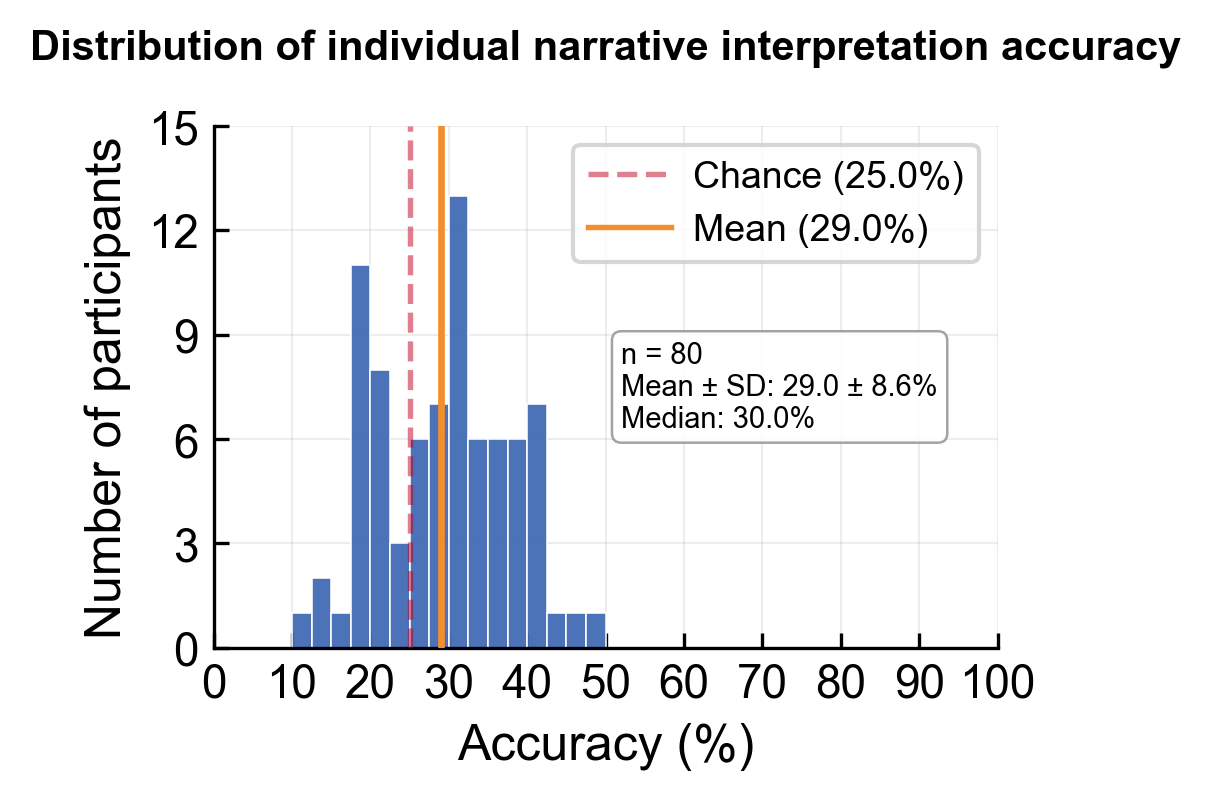

Statistical Results:
Mean Accuracy: 28.98%
Standard Deviation: 8.59%
Median Accuracy: 30.00%
IQR: 16.00%
Range: 12.00% - 48.00%
Participants < 50% Accuracy: 80 (100.0%)
Sample Size: 80
T-Statistic (vs chance 25.0%): 4.14
P-Value (t-test vs chance): 0.0001
Mean difference vs chance: 3.98%
95% CI for mean accuracy: [27.06%, 30.89%]
Cohen's d vs chance: 0.46


In [4]:
FIGSIZE = (3.5, 2.8)

scores = participant_demographics['accuracy'].to_numpy(dtype=float) * 100.0
chance_level = 25.0

mean_acc   = float(np.mean(scores))
std_acc    = float(np.std(scores, ddof=1))
median_acc = float(np.median(scores))
n_participants = scores.size
t_stat, p_value = ttest_1samp(scores, chance_level)
stat_norm, p_norm = normaltest(scores)

fig, ax = plt.subplots(figsize=FIGSIZE, dpi=300)

bins = np.arange(0, 100 + 2.5, 2.5)
counts, edges, patches = ax.hist(
    scores, bins=bins,
    color=PRIMARY_BLUE, edgecolor='white', linewidth=0.4, alpha=0.95
)

ax.axvline(chance_level, color=CHANCE_RED, linestyle='--', linewidth=1.3,
           label=f'Chance ({chance_level:.1f}%)', zorder=3, alpha=0.5)
ax.axvline(mean_acc, color=ACCENT_ORANGE, linestyle='-', linewidth=1.6,
           label=f'Mean ({mean_acc:.1f}%)', zorder=3)

ax.set_xlabel('Accuracy (%)')
ax.set_ylabel('Number of participants')
ax.set_xlim(0, 100)
ax.set_xticks(np.arange(0, 101, 10))

plot_title = "Distribution of individual narrative interpretation accuracy"
if plot_title:
    ax.set_title(plot_title, fontsize=10, fontweight='bold', pad=16)

y_max = max(counts) if counts.size else 1
ax.set_ylim(0, y_max * 1.15)
yt_step = max(1, int(np.ceil(y_max / 6)))
ax.set_yticks(np.arange(0, int(y_max * 1.15) + yt_step, yt_step))

ax.grid(True, alpha=0.22, linewidth=0.5)
ax.set_axisbelow(True)

leg = ax.legend(loc='upper right', frameon=True, handlelength=2.2, handletextpad=0.6)
for line in leg.get_lines():
    line.set_linewidth(1.3)

stats_lines = [
    f"n = {n_participants}",
    f"Mean ± SD: {mean_acc:.1f} ± {std_acc:.1f}%",
    f"Median: {median_acc:.1f}%"
]

ax.text(
    0.52, 0.5, "\n".join(stats_lines),
    transform=ax.transAxes, ha='left', va='center',
    bbox=dict(boxstyle='round,pad=0.32', facecolor='white', edgecolor='0.6',
              alpha=0.9, linewidth=0.6),
    fontsize=7
)

plt.tight_layout()
plt.show()

print("Statistical Results:")
print(f"Mean Accuracy: {mean_acc:.2f}%")
print(f"Standard Deviation: {std_acc:.2f}%")
print(f"Median Accuracy: {median_acc:.2f}%")
print(f"IQR: {stats.iqr(scores):.2f}%")
print(f"Range: {np.min(scores):.2f}% - {np.max(scores):.2f}%")
print(f"Participants < 50% Accuracy: {np.sum(scores < 50)} ({np.sum(scores < 50)/n_participants*100:.1f}%)")
print(f"Sample Size: {n_participants}")
print(f"T-Statistic (vs chance {chance_level:.1f}%): {t_stat:.2f}")
print(f"P-Value (t-test vs chance): {p_value:.4f}")
mean_diff = mean_acc - chance_level
cohen_d = (mean_acc - chance_level) / std_acc if std_acc > 0 else np.nan
se_mean = std_acc / np.sqrt(n_participants)
t_crit = stats.t.ppf(0.975, n_participants - 1)
ci_low = mean_acc - t_crit * se_mean
ci_high = mean_acc + t_crit * se_mean
print(f"Mean difference vs chance: {mean_diff:.2f}%")
print(f"95% CI for mean accuracy: [{ci_low:.2f}%, {ci_high:.2f}%]")
print(f"Cohen's d vs chance: {cohen_d:.2f}")

## 2. Figure 2: Agreement vs Accuracy harmonized

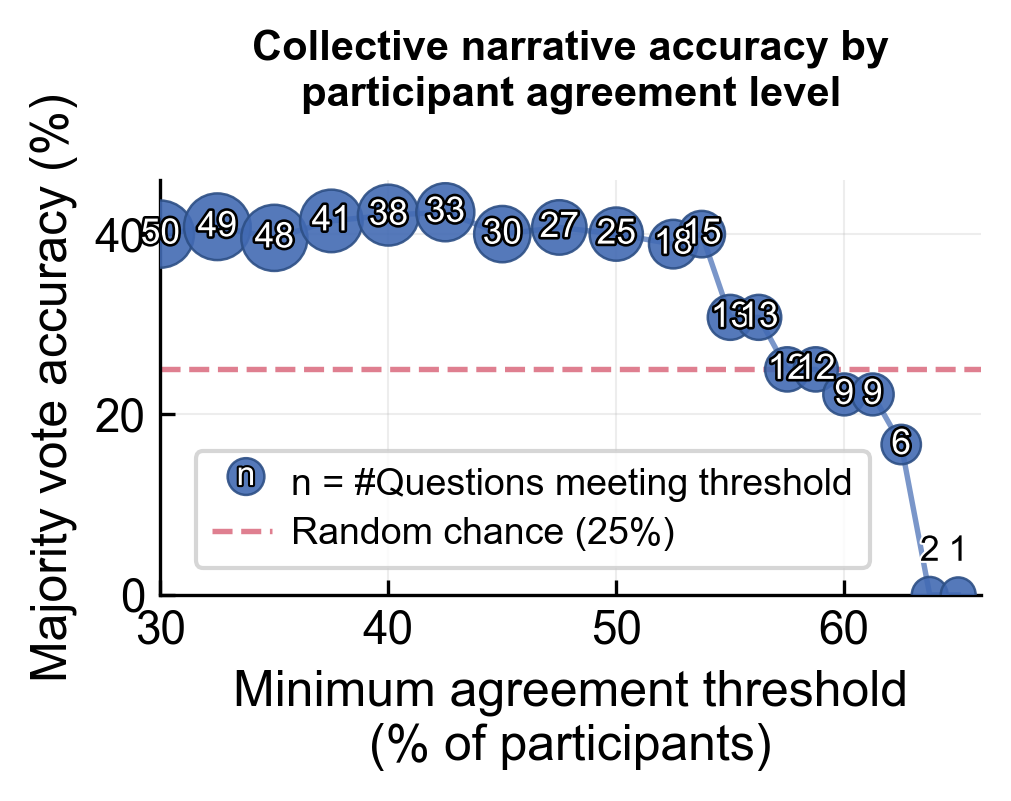

Spearman ρ = -0.753 (p = 2.50e-06)
Linear slope = -0.852 (p = 9.43e-07)
Collective Accuracy (>= 50% agreement): 40.0%
Collective Accuracy (>= 30% agreement): 40.0%


In [5]:
# --- small helper to draw a legend circle with "n" inside ---
class CircleWithText(mpatches.Circle):
    def __init__(self, text='n', **kwargs):
        super().__init__((0, 0), radius=0.5, **kwargs)
        self.text_inside = text

class HandlerCircleWithText(HandlerPatch):
    def __init__(self, scale=1.8, txt_scale=0.85, xshift=0.18):
        super().__init__()
        self.scale = scale
        self.txt_scale = txt_scale
        self.xshift = xshift
        
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        width  *= self.scale
        height *= self.scale
        r  = height / 2.0
        cx = xdescent + width/2.0 - self.xshift*width
        cy = ydescent + height/2.0
        circ = mpatches.Circle((cx, cy), r,
                               facecolor=orig_handle.get_facecolor(),
                               edgecolor=orig_handle.get_edgecolor(),
                               lw=orig_handle.get_linewidth(),
                               alpha=orig_handle.get_alpha(),
                               transform=trans)
        txt = plt.Text(cx, cy, orig_handle.text_inside,
                       ha='center', va='center',
                       fontsize=fontsize*self.txt_scale, color='white',
                       transform=trans,
                       path_effects=[pe.withStroke(linewidth=1, foreground='black')])
        return [circ, txt]

def analyze_k_agreement_benefits():
    answer_cols = get_participant_columns('answer')
    num_participants = len(answer_cols)
    k_values, k_agreements, k_counts = [], [], []
    for k in range(1, num_participants + 1):
        qs, correct = [], 0
        for idx, row in test_responses_df.iterrows():
            vote_counts = pd.Series([row[c] for c in answer_cols]).value_counts()
            if not vote_counts.empty and vote_counts.iloc[0] >= k:
                qs.append(idx)
                if vote_counts.index[0] == row['correct_answer_letter']:
                    correct += 1
        k_values.append(k)
        k_counts.append(len(qs))
        k_agreements.append(correct / len(qs) if len(qs) > 0 else np.nan)
    return k_values, k_agreements, k_counts, num_participants

k_values, k_agreements, k_counts, num_participants = analyze_k_agreement_benefits()
df = pd.DataFrame({'k': k_values, 'acc': k_agreements, 'count': k_counts})
df = df.dropna(subset=['acc'])
df['agreement_pct'] = (df['k'] / num_participants) * 100
df_f = df[df['agreement_pct'] >= 30].copy()

spearman_corr, spearman_p = spearmanr(df_f['agreement_pct'], df_f['acc']*100)
lin_reg = linregress(df_f['agreement_pct'], df_f['acc']*100)

# --- Subsample policy ---
threshold_pct = 53.0
keep_below = 10
pct = df_f['agreement_pct'].to_numpy()
idx_all = np.arange(len(df_f))
idx_below = idx_all[pct < threshold_pct]
idx_above = idx_all[pct >= threshold_pct]

if len(idx_below) > 0:
    k = min(keep_below, len(idx_below))
    sel_below = idx_below[np.linspace(0, len(idx_below) - 1, k).round().astype(int)]
else:
    sel_below = np.array([], dtype=int)

sel_indices = np.concatenate([sel_below, idx_above])
sel_indices.sort()
df_disp = df_f.iloc[sel_indices].copy().sort_values('agreement_pct')

x_disp   = df_disp['agreement_pct'].to_list()
y_disp   = (df_disp['acc'] * 100).to_list()
cnt_disp = df_disp['count'].to_list()

# marker sizes
min_size, max_size = 70, 260   # pt^2
if len(cnt_disp) > 0:
    mn, mx = min(cnt_disp), max(cnt_disp)
    if mx > mn:
        sizes = [min_size + (max_size - min_size) * (c - mn) / (mx - mn) for c in cnt_disp]
    else:
        sizes = [max_size for _ in cnt_disp]
else:
    sizes = [min_size]

fig, ax = plt.subplots(figsize=(3.5, 2.8), dpi=300)

ax.scatter(x_disp, y_disp, s=sizes, facecolor=PRIMARY_BLUE,
           edgecolor='#2D4F85', linewidth=0.6, alpha=0.9, zorder=3)
ax.plot(x_disp, y_disp, color=PRIMARY_BLUE, alpha=0.7, linewidth=1.3, zorder=2)

ax.set_xlabel('Minimum agreement threshold\n(% of participants)')
ax.set_ylabel('Majority vote accuracy (%)')
ax.set_xlim(30, 66)
ax.set_ylim(0, 46)
ax.grid(True, alpha=0.22, linewidth=0.5)
ax.set_axisbelow(True)

chance_handle = mlines.Line2D([], [], linestyle='--', color=CHANCE_RED, alpha=0.5, linewidth=1.3)
ax.axhline(25, color=CHANCE_RED, linestyle='--', linewidth=1.3, alpha=0.5, zorder=1)

circle_n = CircleWithText(text='n', facecolor=PRIMARY_BLUE, edgecolor='#2D4F85', lw=0.6, alpha=0.9)
legend_handles = [circle_n, chance_handle]
legend_labels  = ["n = #Questions meeting threshold", "Random chance (25%)"]

plot_title = "Collective narrative accuracy by\nparticipant agreement level"
if plot_title:
    ax.set_title(plot_title, fontsize=10, fontweight='bold', pad=18)

ax.legend(
    handles=legend_handles,
    labels=legend_labels,
    handler_map={CircleWithText: HandlerCircleWithText(scale=1.4, txt_scale=0.9, xshift=0.10)},
    loc='lower left',
    frameon=True,
    handlelength=1.6,
    handletextpad=0.5,
    labelspacing=0.4,
    borderpad=0.45,
    bbox_to_anchor=(0.02, 0.02)
)

radii = [sqrt(s/pi) for s in sizes]
INSIDE_MIN_R = 5.0
OUT_SHIFT = 3.0
for x, y, n, r in sorted(zip(x_disp, y_disp, cnt_disp, radii), key=lambda t: t[3], reverse=True):
    if r >= INSIDE_MIN_R:
        ax.text(x, y, str(n), ha='center', va='center', fontsize=8.5, color='white', zorder=4,
                path_effects=[pe.withStroke(linewidth=1.25, foreground='black')])
    else:
        ax.text(x, y + OUT_SHIFT, str(n), ha='center', va='bottom', fontsize=8.5, color='black', zorder=4,
                path_effects=[pe.withStroke(linewidth=1.0, foreground='white')])

plt.tight_layout()
plt.show()

print(f"Spearman ρ = {spearman_corr:.3f} (p = {spearman_p:.2e})")
print(f"Linear slope = {lin_reg.slope:.3f} (p = {lin_reg.pvalue:.2e})")

# Collective Accuracy Stats
acc_50 = df.loc[df['agreement_pct'] == 50.0, 'acc']
if not acc_50.empty:
    print(f"Collective Accuracy (>= 50% agreement): {acc_50.values[0]*100:.1f}%")

acc_30 = df.loc[df['agreement_pct'] == 30.0, 'acc']
if not acc_30.empty:
    print(f"Collective Accuracy (>= 30% agreement): {acc_30.values[0]*100:.1f}%")

## 3. Table 1: Participant Demographics and Task Accuracy Analysis

In [6]:
# Consolidated Demographic Analysis Functions
STEM_KEYWORDS = [
    'computer science', 'engineering', 'mathematics', 'physics', 'chemistry', 
    'biology', 'science', 'technology', 'data', 'software', 'programming',
    'medicine', 'dentistry', 'pharmacy', 'veterinary', 'nursing', 'psychology'
]

def median_ci(data, alpha=0.05, n_bootstrap=1000):
    if len(data) == 0: return np.nan, np.nan, np.nan
    bootstrap_medians = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_medians.append(np.median(sample))
    ci_low = np.percentile(bootstrap_medians, (alpha/2) * 100)
    ci_high = np.percentile(bootstrap_medians, (1 - alpha/2) * 100)
    return np.median(data), ci_low, ci_high

def mann_whitney_effect_size(group1, group2):
    if len(group1) == 0 or len(group2) == 0: return np.nan
    n1, n2 = len(group1), len(group2)
    u_stat, _ = mannwhitneyu(group1, group2, alternative='two-sided')
    z_score = abs((u_stat - (n1 * n2) / 2) / np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12))
    return z_score / np.sqrt(n1 + n2)

def classify_stem_field(field):
    if pd.isna(field): return None
    field_str = str(field).lower()
    return any(keyword in field_str for keyword in STEM_KEYWORDS)

def map_education_level(edu):
    if pd.isna(edu): return None
    edu_str = str(edu).lower()
    if 'doctorate' in edu_str or 'phd' in edu_str: return None
    elif 'bachelor' in edu_str: return 'Bachelor'
    elif 'master' in edu_str: return 'Master'
    return 'Other'

def compare_two_groups(group1, group2, name1, name2):
    if len(group1) == 0 or len(group2) == 0:
        return {'n1': len(group1), 'n2': len(group2), 'median1': np.nan, 'median2': np.nan, 'statistic': np.nan, 'p_value': np.nan, 'effect_size': np.nan}
    med1, _, _ = median_ci(group1)
    med2, _, _ = median_ci(group2)
    statistic, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
    effect_size = mann_whitney_effect_size(group1, group2)
    return {'n1': len(group1), 'n2': len(group2), 'median1': med1, 'median2': med2, 'statistic': statistic, 'p_value': p_value, 'effect_size': effect_size}

def analyze_all_demographics():
    demo_data = participant_demographics.copy()
    demo_data['is_stem'] = demo_data['Bachelor Degree Field'].apply(classify_stem_field)
    demo_data['degree_level'] = demo_data['Education'].apply(map_education_level)
    
    results = {}
    # 1. STEM
    stem_data = demo_data[demo_data['is_stem'] == True]['accuracy'].dropna()
    non_stem_data = demo_data[demo_data['is_stem'] == False]['accuracy'].dropna()
    results['stem_analysis'] = compare_two_groups(stem_data, non_stem_data, "STEM", "Non-STEM")
    
    # 2. Education
    bachelor_data = demo_data[demo_data['degree_level'] == 'Bachelor']['accuracy'].dropna()
    master_data = demo_data[demo_data['degree_level'] == 'Master']['accuracy'].dropna()
    results['education_analysis'] = compare_two_groups(bachelor_data, master_data, "Bachelor", "Master")
    results['education_analysis']['groups'] = {'Bachelor': bachelor_data, 'Master': master_data}
    
    # 3. AI Usage
    usage_map = {'multiple-times-day': 6, 'once-week': 3, 'rarely': 2, 'never': 1}
    ai_clean = demo_data.dropna(subset=['AI Use Frequency', 'accuracy']).copy()
    ai_clean['usage_ordinal'] = ai_clean['AI Use Frequency'].map(usage_map)
    ai_clean = ai_clean.dropna(subset=['usage_ordinal'])
    if len(ai_clean) > 0:
        rho, p_val = spearmanr(ai_clean['usage_ordinal'], ai_clean['accuracy'])
        results['ai_usage_analysis'] = {'rho': rho, 'p_value': p_val, 'n': len(ai_clean)}
    else:
        results['ai_usage_analysis'] = {'rho': np.nan, 'p_value': np.nan, 'n': 0}
        
    # 4. CoT Familiarity
    cot_data = demo_data.dropna(subset=['Familiar Feature', 'accuracy'])
    if len(cot_data) > 0:
        familiar = cot_data[cot_data['Familiar Feature'].str.lower() == 'yes']['accuracy']
        unfamiliar = cot_data[cot_data['Familiar Feature'].str.lower() == 'no']['accuracy']
        results['cot_analysis'] = compare_two_groups(familiar, unfamiliar, "Familiar", "Unfamiliar")
    else:
        results['cot_analysis'] = compare_two_groups([], [], "Familiar", "Unfamiliar")

    # 5. Expected Performance (Likert3)
    likert_data = demo_data.dropna(subset=['Likert3', 'accuracy']).copy()
    likert_data['likert_val'] = pd.to_numeric(likert_data['Likert3'], errors='coerce')
    likert_data = likert_data.dropna(subset=['likert_val'])
    
    if len(likert_data) > 0:
        rho_likert, p_val_likert = spearmanr(likert_data['likert_val'], likert_data['accuracy'])
        results['expected_performance_analysis'] = {'rho': rho_likert, 'p_value': p_val_likert, 'n': len(likert_data)}
    else:
        results['expected_performance_analysis'] = {'rho': np.nan, 'p_value': np.nan, 'n': 0}
        
    return results

demographic_results = analyze_all_demographics()

# Create Table
stem_res = demographic_results['stem_analysis']
edu_res = demographic_results['education_analysis']
ai_res = demographic_results['ai_usage_analysis']
cot_res = demographic_results['cot_analysis']
exp_res = demographic_results['expected_performance_analysis']

# Calculate U statistic context
stem_max_u = stem_res["n1"] * stem_res["n2"]
stem_u_pct = (stem_res["statistic"] / stem_max_u) * 100 if stem_max_u > 0 else 0

cot_max_u = cot_res["n1"] * cot_res["n2"]
cot_u_pct = (cot_res["statistic"] / cot_max_u) * 100 if cot_max_u > 0 else 0

edu_bach_n = len(edu_res["groups"].get("Bachelor", []))
edu_master_n = len(edu_res["groups"].get("Master", []))
edu_max_u = edu_bach_n * edu_master_n if edu_bach_n > 0 and edu_master_n > 0 else 1
edu_stat = edu_res["statistic"]
edu_u_pct = (edu_stat / edu_max_u) * 100 if edu_max_u > 1 else 0

# AI Usage Low/High for table display
ai_col = [col for col in participant_demographics.columns if 'ai' in col.lower() or 'usage' in col.lower()][0]
low_freq_values = ['once-month-or-less', 'once-week']
high_freq_values = ['few-times-week', 'once-day', 'multiple-times-day']
ai_participants = participant_demographics.dropna(subset=[ai_col])
low_freq = ai_participants[ai_participants[ai_col].isin(low_freq_values)]
high_freq = ai_participants[ai_participants[ai_col].isin(high_freq_values)]
ai_low_n = len(low_freq)
ai_high_n = len(high_freq)
ai_low_med = f"{participant_demographics.loc[low_freq.index, 'accuracy'].median()*100:.1f}%" if ai_low_n > 0 else "N/A"
ai_high_med = f"{participant_demographics.loc[high_freq.index, 'accuracy'].median()*100:.1f}%" if ai_high_n > 0 else "N/A"

contextualized_table_data = {
    'Factor': ['Academic background', 'Education level', 'Reasoning familiarity', 'AI usage frequency', 'Expected performance'],
    'Analysis': ['Mann-Whitney U', 'Mann-Whitney U', 'Mann-Whitney U', 'Spearman ρ', 'Spearman ρ'],
    'Group 1 (n, median)': [
        f'STEM ({stem_res["n1"]}, {stem_res["median1"]*100:.1f}%)',
        f'Bachelor ({edu_bach_n}, {median_ci(edu_res["groups"].get("Bachelor", []))[0]*100:.1f}%)',
        f'Yes ({cot_res["n1"]}, {cot_res["median1"]*100:.1f}%)',
        '—',
        '—'
    ],
    'Group 2 (n, median)': [
        f'Non-STEM ({stem_res["n2"]}, {stem_res["median2"]*100:.1f}%)',
        f'Master+ ({edu_master_n}, {median_ci(edu_res["groups"].get("Master", []))[0]*100:.1f}%)',
        f'No ({cot_res["n2"]}, {cot_res["median2"]*100:.1f}%)',
        '—',
        '—'
    ],
    'Test Statistic (Contextualized)': [
        f'U = {stem_res["statistic"]:.1f}',
        f'U = {edu_stat:.1f}',
        f'U = {cot_res["statistic"]:.1f}',
        f'ρ = {ai_res["rho"]:.3f}',
        f'ρ = {exp_res["rho"]:.3f}'
    ],
    'Effect Size': [
        f'{stem_res["effect_size"]:.3f}',
        f'{edu_res["effect_size"]:.3f}',
        f'{cot_res["effect_size"]:.3f}',
        '—',
        '—'
    ],
    'p-value': [
        f'{stem_res["p_value"]:.3f}',
        f'{edu_res["p_value"]:.3f}',
        f'{cot_res["p_value"]:.3f}',
        f'{ai_res["p_value"]:.3f}',
        f'{exp_res["p_value"]:.3f}'
    ]
}

contextualized_table = pd.DataFrame(contextualized_table_data)
print("\n=== TABLE 1: PARTICIPANT DEMOGRAPHICS AND TASK ACCURACY ANALYSIS ===")
display(contextualized_table)


=== TABLE 1: PARTICIPANT DEMOGRAPHICS AND TASK ACCURACY ANALYSIS ===


,Factor,Analysis,"Group 1 (n, median)","Group 2 (n, median)",Test Statistic (Contextualized),Effect Size,p-value
0,Academic background,Mann-Whitney U,"STEM (37, 28.0%)","Non-STEM (31, 30.0%)",U = 551.0,0.034,0.786
1,Education level,Mann-Whitney U,"Bachelor (47, 28.0%)","Master+ (28, 29.0%)",U = 536.5,0.154,0.183
2,Reasoning familiarity,Mann-Whitney U,"Yes (68, 29.0%)","No (12, 30.0%)",U = 400.0,0.012,0.919
3,AI usage frequency,Spearman ρ,—,—,ρ = -0.047,—,0.727
4,Expected performance,Spearman ρ,—,—,ρ = -0.087,—,0.442


## 4. Figure 3: Position effects on accuracy and response time

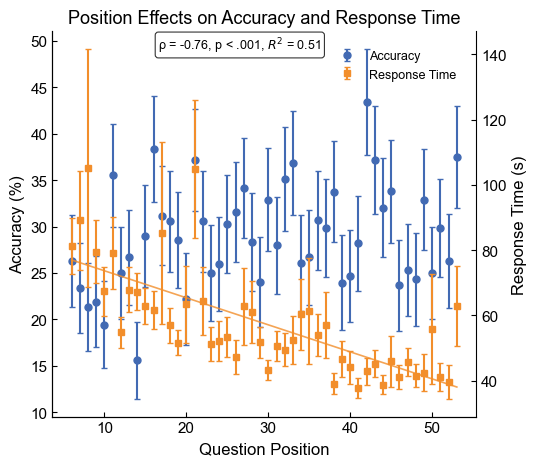

In [7]:
# Extract position data
position_data = []
for _, p in participant_demographics.iterrows():
    pid = p['Prolific ID']
    order = json.loads(p['Shuffled Question Order']) if isinstance(p['Shuffled Question Order'], str) else p['Shuffled Question Order']
    
    for pos_idx, q_num in enumerate(order):
        pos = pos_idx + 1
        if pos <= 5: continue  # Skip first 5 positions
        
        row = test_responses_df[test_responses_df['question_num'] == q_num]
        if row.empty: continue
        
        answer = row.iloc[0][f"{pid}_answer"]
        if pd.notna(answer):
            position_data.append({
                'position': pos,
                'correct': row.iloc[0][f"{pid}_correct"],
                'time': row.iloc[0][f"{pid}_time"]
            })

df_pos = pd.DataFrame(position_data)
stats_df = df_pos.groupby('position').agg({
    'correct': ['count', 'mean', 'std'],
    'time': ['mean', 'std']
}).round(4)

stats_df.columns = ['n', 'acc', 'acc_std', 'time', 'time_std']
stats_df = stats_df.reset_index()
stats_df['acc_se'] = stats_df['acc_std'] / np.sqrt(stats_df['n'])
stats_df['time_se'] = stats_df['time_std'] / np.sqrt(stats_df['n'])

fig, ax1 = plt.subplots(figsize=(5.5, 4.8))

# Left axis: Accuracy
x  = stats_df['position']
y1 = stats_df['acc'] * 100
e1 = stats_df['acc_se'] * 100

acc_handle = ax1.errorbar(
    x, y1, yerr=e1,
    fmt='o', color=PRIMARY_BLUE,
    capsize=2.5, markersize=5,
    label='Accuracy'
)

ax1.set_xlabel('Question Position')
ax1.set_ylabel('Accuracy (%)')

# Right axis: Response Time
ax2 = ax1.twinx()
y2  = stats_df['time']
e2  = stats_df['time_se']

time_handle = ax2.errorbar(
    x, y2, yerr=e2,
    fmt='s', color=ACCENT_ORANGE,
    capsize=2.5, markersize=5,
    label='Response Time'
)

# Correlations
acc_r, acc_p = stats.spearmanr(stats_df['position'], stats_df['acc'])
time_r, time_p = stats.spearmanr(stats_df['position'], stats_df['time'])

# Trend line if significant
if time_p < 0.05:
    slope, intercept = np.polyfit(x, y2, 1)
    ax2.plot(x, slope * x + intercept,
             '-', color=ACCENT_ORANGE, linewidth=1.2, alpha=0.8)

ax2.set_ylabel('Response Time (s)')
ax2.spines['right'].set_visible(True)
ax2.spines['right'].set_color('black')
ax2.spines['right'].set_linewidth(0.8)
ax2.tick_params(axis='y', which='both', color='black', labelcolor='black')

for ax in (ax1, ax2):
    ax.tick_params(axis='both', color='black', labelcolor='black')

time_linreg = linregress(stats_df['position'], stats_df['time'])
stats_txt = r'ρ = {:+.2f}, p < .001, $R^2$ = {:.2f}'.format(time_r, time_linreg.rvalue**2)
ax1.text(
    0.25, 0.99, stats_txt, transform=ax1.transAxes,
    va='top', ha='left', fontsize=9,
    bbox=dict(boxstyle='round,pad=0.25', facecolor='white', alpha=0.8, linewidth=0.8)
)

ax1.legend(
    [acc_handle, time_handle], ['Accuracy', 'Response Time'],
    loc='upper right',
    bbox_to_anchor=(0.98, 0.98),
    frameon=False
)
plt.title('Position Effects on Accuracy and Response Time')
fig.subplots_adjust(top=0.88)
plt.tight_layout()
plt.show()

## 5. Statistical Analyses

### 5.1 Model Comparison (Mixed-Effects Logistic Regression & Wilcoxon)

In [8]:
print("=== Mixed-Effects Logistic Regression Analysis ===")

# Prepare data for analysis
participant_data = []
participant_cols = [col for col in test_responses_df.columns if col.endswith('_correct')]
participant_ids = [col.replace('_correct', '') for col in participant_cols]

for _, row in test_responses_df.iterrows():
    question_num = row['question_num']
    model_name = row['model_name']
    for pid in participant_ids:
        correct_col = f"{pid}_correct"
        if correct_col in test_responses_df.columns:
            is_correct = row[correct_col]
            participant_data.append({
                'participant_id': pid,
                'question_num': question_num,
                'model_name': model_name,
                'correct': int(is_correct),
                'accuracy': int(is_correct)
            })

df_long = pd.DataFrame(participant_data)

# Mixed-Effects Logistic Regression (GEE)
try:
    formula = 'correct ~ model_name'
    model_gee = smf.gee(formula, groups='participant_id', data=df_long, family=sm.families.Binomial())
    result_gee = model_gee.fit()
    print("GEE Model Results (Model Comparison):")
    print(result_gee.summary())
except Exception as e:
    print(f"GEE model failed: {e}")

# Wilcoxon Signed-Rank Test
print("\n=== Wilcoxon Signed-Rank Test Results ===")
participant_model_acc = df_long.groupby(['participant_id', 'model_name'])['accuracy'].mean().reset_index()
pivot_data = participant_model_acc.pivot(index='participant_id', columns='model_name', values='accuracy')

if len(pivot_data.columns) == 2:
    model1_name, model2_name = pivot_data.columns[0], pivot_data.columns[1]
    paired_data = pivot_data.dropna()
    if len(paired_data) > 0:
        model1_acc = paired_data[model1_name]
        model2_acc = paired_data[model2_name]
        stat, p_value = wilcoxon(model1_acc, model2_acc)
        print(f"Wilcoxon signed-rank test between {model1_name} and {model2_name}:")
        print(f"Test statistic: {stat:.4f}, P-value: {p_value:.4f}")
        print(f"Mean {model1_name}: {model1_acc.mean():.3f} (SD={model1_acc.std():.3f})")
        print(f"Mean {model2_name}: {model2_acc.mean():.3f} (SD={model2_acc.std():.3f})")

=== Mixed-Effects Logistic Regression Analysis ===
GEE Model Results (Model Comparison):
                               GEE Regression Results                              
Dep. Variable:                     correct   No. Observations:                 4000
Model:                                 GEE   No. clusters:                       80
Method:                        Generalized   Min. cluster size:                  50
                      Estimating Equations   Max. cluster size:                  50
Family:                           Binomial   Mean cluster size:                50.0
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Wed, 26 Nov 2025   Scale:                           1.000
Covariance type:                    robust   Time:                         10:32:56
                                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------

### 5.2 Response Time vs Accuracy (GEE Regression)

In [9]:
print("=== GEE Analysis: Response Time vs Accuracy ===")

# Derive participant IDs locally to avoid cross-cell dependency
participant_cols = [col for col in test_responses_df.columns if col.endswith('_correct')]
participant_ids = [col.replace('_correct', '') for col in participant_cols]

# Calculate Global Response Time Stats (before filtering for GEE but after initial load)
all_times = []
for _, row in test_responses_df.iterrows():
    for pid in participant_ids:
        t = row.get(f"{pid}_time")
        if pd.notna(t):
            all_times.append(t)

all_times = np.array(all_times)
filtered_times = all_times[all_times <= LONG_THRESHOLD_SEC]
n_removed = len(all_times) - len(filtered_times)
pct_removed = (n_removed / len(all_times)) * 100

print(f"Global Response Time Stats:")
print(f"Mean: {np.mean(filtered_times):.1f}s")
print(f"SD: {np.std(filtered_times):.1f}s")
print(f"Median: {np.median(filtered_times):.1f}s")
print(f"Filtered {n_removed} extreme measurements ({pct_removed:.2f}%)")
# Paper-style filtering: exclude non-positive times and >400s only (retain all others)
paper_times = all_times[(all_times > 0) & (all_times <= LONG_THRESHOLD_SEC)]
paper_mean = np.mean(paper_times)
paper_sd = np.std(paper_times, ddof=1)
paper_median = np.median(paper_times)
paper_removed = len(all_times) - len(paper_times)
paper_pct_removed = paper_removed / len(all_times) * 100
print(f"Paper-style stats (0 < t <= 400): Mean={paper_mean:.1f}s SD={paper_sd:.1f}s Median={paper_median:.1f}s Removed={paper_removed} ({paper_pct_removed:.2f}%)")

# Prepare data for RT analysis (build df_rt before any use)
rt_data = []
for _, row in test_responses_df.iterrows():
    for pid in participant_ids:
        time_col = f"{pid}_time"
        correct_col = f"{pid}_correct"
        if time_col in test_responses_df.columns and correct_col in test_responses_df.columns:
            rt = row[time_col]
            correct = row[correct_col]
            if pd.notna(rt) and pd.notna(correct):
                # Filter outliers (e.g., > 400s) and exclude non-positive times
                if rt <= LONG_THRESHOLD_SEC and rt > 0:
                    rt_data.append({
                        'participant_id': pid,
                        'response_time': rt,
                        'log_rt': np.log(rt),
                        'correct': int(correct)
                    })

df_rt = pd.DataFrame(rt_data)

# Participant-level aggregation for slope comparable to manuscript beta
participant_rt_acc = df_rt.groupby('participant_id').agg(mean_rt=('response_time','mean'), acc=('correct','mean')).reset_index()
prt_lin = linregress(participant_rt_acc['mean_rt'], participant_rt_acc['acc'])
print(f"Participant-level accuracy~mean_rt linear regression: slope={prt_lin.slope:.5f} p={prt_lin.pvalue:.3f} R^2={prt_lin.rvalue**2:.3f}")
rho_part, p_part = spearmanr(participant_rt_acc['mean_rt'], participant_rt_acc['acc'])
print(f"Participant-level Spearman ρ={rho_part:.3f} p={p_part:.3f}")

# GEE Model: correct ~ log_rt
try:
    model_rt = smf.gee("correct ~ log_rt", groups="participant_id", data=df_rt, family=sm.families.Binomial())
    result_rt = model_rt.fit()
    print(result_rt.summary())
    
    # Also try with raw response time
    print("\n--- GEE with raw Response Time ---")
    model_rt_raw = smf.gee("correct ~ response_time", groups="participant_id", data=df_rt, family=sm.families.Binomial())
    result_rt_raw = model_rt_raw.fit()
    print(result_rt_raw.summary())
    
    # Extract specific coefficient for paper
    beta_rt = result_rt_raw.params['response_time']
    p_rt = result_rt_raw.pvalues['response_time']
    print(f"\nResponse Time Coefficient (beta): {beta_rt:.3f}")
    print(f"Response Time P-value: {p_rt:.3f}")
    
except Exception as e:
    print(f"GEE analysis failed: {e}")

=== GEE Analysis: Response Time vs Accuracy ===
Global Response Time Stats:
Mean: 56.7s
SD: 52.8s
Median: 41.6s
Filtered 45 extreme measurements (1.13%)
Paper-style stats (0 < t <= 400): Mean=56.7s SD=52.8s Median=41.6s Removed=45 (1.13%)
Participant-level accuracy~mean_rt linear regression: slope=0.00118 p=0.003 R^2=0.110
Participant-level Spearman ρ=0.301 p=0.007
                               GEE Regression Results                              
Dep. Variable:                     correct   No. Observations:                 3946
Model:                                 GEE   No. clusters:                       80
Method:                        Generalized   Min. cluster size:                  46
                      Estimating Equations   Max. cluster size:                  50
Family:                           Binomial   Mean cluster size:                49.3
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Wed, 26 Nov 2025  